In [1]:
# import libraries
from bs4 import BeautifulSoup
import numpy as np
from time import sleep
from random import randint
import pandas as pd

import requests
import time

In [2]:
def a_tag_with_id(tag):
    return tag.name == 'a' and tag.has_attr('data-test-id')

In [3]:
# find links to each job's own page
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36", "Accept-Encoding":"gzip, deflate, br", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

pages = np.arange(1, 100, 1)
link = []

# these are all Applications Developer Job postings
for page in pages: 
    page = "https://www.monster.com/jobs/q-applications-developer-jobs?page=" + str(page)

    request_page = requests.get(page, headers=headers)
    sleep(randint(2,10))
    html_soup = BeautifulSoup(request_page.content, "html.parser")
    soup = BeautifulSoup(html_soup.prettify())
    container = soup.find_all(a_tag_with_id)
    
    for line in container:
        if line.get('href') not in link:
            link.append(line.get('href'))

In [4]:
len(link)

157

In [5]:
# create dataframe for storing the data later
df = pd.DataFrame(columns=['job_title', 'company', 'description', 'has_company_logo'])

In [6]:
def clean_text(lists):
    lists = list(map(lambda x: x.replace("\n", ""), lists))
    lists = list(map(lambda x: x.strip(), lists))
    return lists

In [7]:
# scrape data then store in the dataframe
alls, has_company_logo = [], 0

for i in range(0,150):
    url = 'http:' + link[i]
    request_page2 = requests.get(url, headers=headers)  
    sleep(randint(10,20))
    html_soup2 = BeautifulSoup(request_page2.content, 'html.parser')
    soup2 = BeautifulSoup(html_soup2.prettify())
    
    job_title_raw = soup2.find_all('h1', class_="headerstyle__JobViewHeaderTitle-sc-1ijq9nh-5 jSWmz JobViewTitle")
    company_raw = soup2.find_all('h2', class_="headerstyle__JobViewHeaderCompany-sc-1ijq9nh-6 vYQlO")
    descript_comp_raw = soup2.find_all('div', class_="descriptionstyles__DescriptionContainer-sc-13ve12b-0 bOxUQy")
    logo_raw = soup2.find_all('div', class_="headerstyle__JobViewHeaderLogo-sc-1ijq9nh-7 jerIfP")
    
    for line in job_title_raw:
        alls.append(line.get_text())
    for line in company_raw:
        alls.append(line.get_text())
    for i in descript_comp_raw:
        result = i.find(class_="descriptionstyles__DescriptionHeader-sc-13ve12b-1 ilDrbq")
        if result.get_text() == '\n           Description\n          ':
            alls.append(i.get_text())
            
    alls = clean_text(alls)
    
    for line in logo_raw:
        result = line.find(class_="company-logostyles__LogoContainer-sc-11vzkdn-1 bZVFkX")
        has_company_logo == 1 if result else has_company_logo == 0

    alls.append(has_company_logo)
    
    try:
        df2 = pd.DataFrame([[j for j in alls]], columns=['job_title', 'company', 'description', 'has_company_logo'])
    except:
        pass
    else:
        df = pd.concat([df, df2], ignore_index=True)
    
    alls = []

In [8]:
df

,job_title,company,description,has_company_logo
0,Applications Engineer,Randstad USA,Description job summary: ...,0
1,AWS Devops Engineer,Inovalon,Description Inovalon is ...,0
2,Applications Engineer,TotalTek,Description Apply Now ...,0
3,APPLICATIONS ENGINEER 3,DANIEL DEFENSE LLC,Description At Daniel De...,0
4,Application Support Engineer,Yoh,Description Application ...,0
...,...,...,...,...
145,Software Engineer,GENERAL ATOMICS,Description General Atomic...,0
146,Senior DevOps Engineer,Santander Holdings USA Inc,Description Description ...,0
147,Controls Programmer,Rex Signature Services,Description Job Details ...,0
148,Quality Assurance Analyst,ULINE,Description Quality Ass...,0


In [105]:
df.to_csv('job-scraping.csv' ,index=False)

# Extract information from description

In [37]:
# concatenate every description into a single text
desc_text = ""
desc = df['description'].astype("string")
for i in range(len(desc)):
    desc_text = desc_text + " " + desc[i]

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

In [28]:
# use spaCy to extract the information
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")

In [41]:
my_stop_words = ['Description', 'Requirements', 'Responsibilities', 'Skills', 'Experience', 'Qualifications', 'Background', 'job']

for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [42]:
doc = nlp(desc_text)

In [60]:
# overall, the label 'ORG' just dominates everything else
for token in doc.ents[:20]:
    print(token.text, token.label_)

the Applications Engineer (AE ORG
AE ORG
AE ORG
AE ORG
Microsoft Office ORG
Quality, Lean ORG
Six CARDINAL
FMEA ORG
DOE ORG
Holliston GPE
Massachusetts                       ORG
hours TIME
8am to TIME
the Applications Engineer (AE ORG
AE ORG
AE ORG
AE ORG
Covid-19 vaccination ORG
Randstad ORG
Gender Identity ORG


In [57]:
# get the 20 most common 'ORG' tokens
orgs = [token.text
         for token in doc.ents
         if (token.label_ == 'ORG')]
orgs_freq = Counter(orgs)

common_orgs = orgs_freq.most_common(20)
common_orgs

[('SQL', 38),
 ('Microsoft', 26),
 ('DevOps', 21),
 ('Computer Science', 18),
 ('Bachelor', 16),
 ('Microsoft Office', 15),
 ('CI', 15),
 ('ETL', 15),
 ('JavaScript', 14),
 ('API', 13),
 ('EF', 12),
 ('Company', 11),
 ('CSS', 11),
 ('Android', 10),
 ('Information Technology', 9),
 ('PTO', 9),
 ('SAS', 9),
 ('Dental', 8),
 ('LLC', 7),
 ('SQL Server', 7)]

In [64]:
# find words frequency to see the most in-demand skills
keywords = {'HTML', 'GUI', 'TOAD', 'IIS', 'Microsoft Visual Studio', 'Oracle', 'Python', 'MATLAB', 'Node.js', 'CSS', 'Java', 'JavaScript', 'Spring', 'Ad-grid', 'Git', 'GitHub', 'BitBucket', 'Jenkins', 'ReactJS', 'Angular', 'Vue', 'iOS', 'Android', 'UI/UX', 'SQL', 'JMS', 'Kafka', 'Azure', 'Rest', 'Jira', 'Artifactory', 'SVN', 'Gradle', 'Apex', 'Visualforce', 'SOQL', 'SOSL', 'C', 'C++', 'C#', '.Net', 'Selenium', 'Maven', 'Adobe', 'Eclipse', 'Sling', 'SOAP', 'LINQ', 'Dapper', 'MVC', 'ADO.NET', 'Bootstrap', 'jQuery', 'AJAX', 'JSON', 'Typescript', 'XML', 'UX', 'TFS', 'WCF', 'RDBMS', 'AWS', 'GLUE', 'Spark', 'Lambda', 'T-SQL', 'Perl', 'Unix', 'SSRS', 'PostgreSQL', 'elasticsearch', 'Django', 'flask', 'GeoTIFF', 'GeoJSON', 'shapefile', 'Linux'}

keys = [token.text
         for token in doc.ents
         if (token.text in keywords)]
key_freq = Counter(keys)

common_keys = key_freq.most_common(10)
common_keys

[('SQL', 41),
 ('Java', 24),
 ('JavaScript', 19),
 ('Git', 15),
 ('CSS', 11),
 ('Android', 10),
 ('Jenkins', 8),
 ('C++', 7),
 ('Python', 6),
 ('Oracle', 6)]

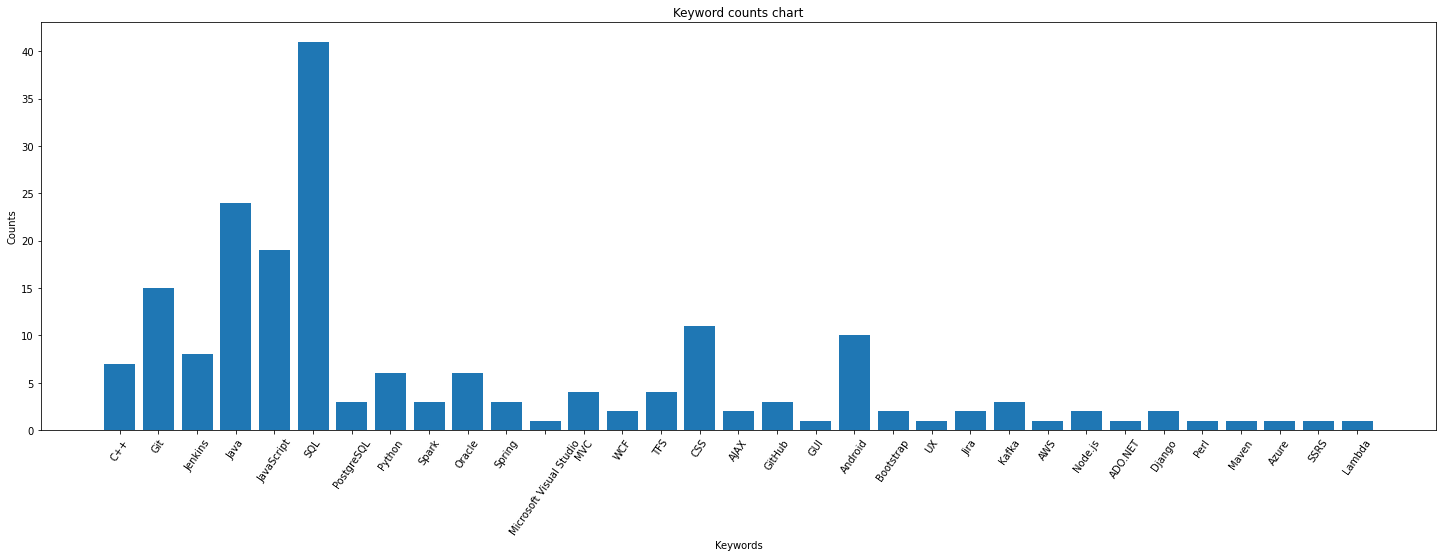

In [104]:
# skill keywords bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 7.5))
plt.xticks(rotation=55)
plt.title('Keyword counts chart')           
plt.xlabel('Keywords')
plt.ylabel('Counts')

keys = key_freq.keys()
keys_count = key_freq.values()
plt.bar(keys, keys_count)
plt.show()